In [11]:
from pathlib import Path

print(Path().absolute())

/home/rohan/dev/tai/src/model/notebooks


In [12]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

from functions import combine_aqi_aaq

In [13]:
district = "Warangal"
aqi_df = pd.read_csv("data/monthly_aqi_data.csv")
aqi_df.head()

,district,month,aqi,year
0,Nizamabad,Jan,61.333333333333336,2017
1,Nizamabad,Feb,61.55555555555556,2017
2,Nizamabad,Mar,63.22222222222222,2017
3,Nizamabad,Apr,67.37037037037038,2017
4,Nizamabad,May,68.40740740740742,2017


In [14]:
aaq_df = pd.read_csv("data/monthly_aaq_data.csv")
aaq_df.head()

,district,month,SO2,NOx,PM10,PM2.5,NH3,year
0,Khammam,Jan,6.0,19.0,46.0,NaN,NaN,2016
1,Khammam,Feb,7.0,19.0,51.0,NaN,NaN,2016
2,Khammam,Mar,6.1,20.7,54.0,NaN,NaN,2016
3,Khammam,Apr,8.0,19.0,51.0,NaN,NaN,2016
4,Khammam,May,7.0,19.0,47.0,NaN,NaN,2016


In [15]:
df = combine_aqi_aaq(aqi_df=aqi_df, aaq_df=aaq_df, district=district)
df.head()

,district,aqi,date,SO2,NOx,PM10
48,Warangal,74.444444,2017-01-01,8.0,25.5,74.5
49,Warangal,73.870370,2017-02-01,8.0,27.0,74.5
50,Warangal,67.907407,2017-03-01,7.5,26.0,68.0
51,Warangal,72.759259,2017-04-01,8.0,27.5,73.0
52,Warangal,69.557870,2017-05-01,8.0,27.0,69.5


In [16]:
df.set_index("date", inplace=True)

<Axes: xlabel='date'>

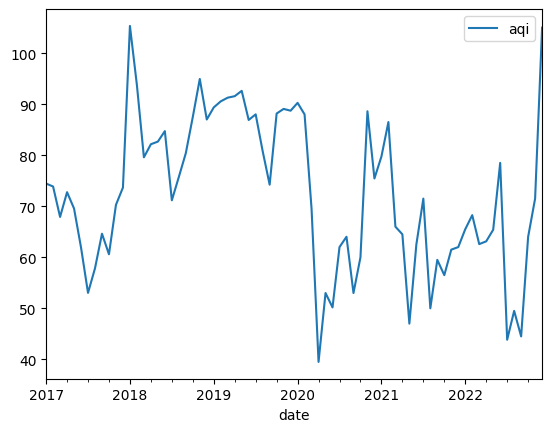

In [17]:
df.plot(y='aqi')

In [18]:
def print_adf_results(adf_result: pd.DataFrame) -> None:
    print('ADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print('\t%s: %.3f' % (key, value))

print_adf_results(adfuller(df['aqi']))

ADF Statistic: -3.212297
p-value: 0.019284
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589


In [19]:
arima_model = sm.tsa.arima.ARIMA(df['aqi'], order=(1, 0, 0))
arima = arima_model.fit()
arima.summary()

/home/rohan/dev/tai/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/rohan/dev/tai/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/rohan/dev/tai/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    aqi   No. Observations:                   72
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -274.934
Date:                Sat, 04 Mar 2023   AIC                            555.867
Time:                        14:48:37   BIC                            562.697
Sample:                    01-01-2017   HQIC                           558.586
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         73.5287      4.351     16.901      0.000      65.002      82.056
ar.L1          0.6980      0.133      5.259      0.000       0.438       0.958
sigma2       120.2911     13.912      8.646      0.000      93.023     147.559
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.27
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.18   Skew:                            -0.11
Prob(H) (two-sided):                  0.06   Kurtosis:                         5.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='date'>

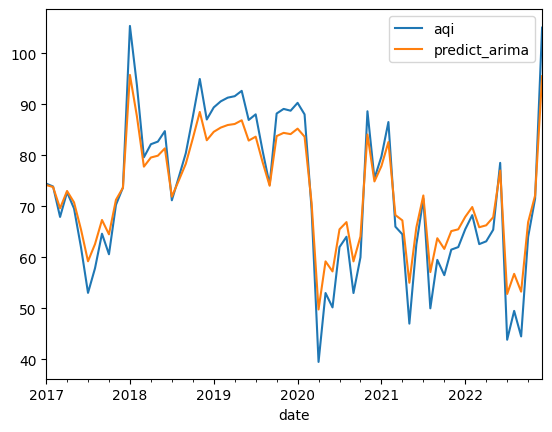

In [20]:
df['predict_arima'] = list(arima.predict(1, len(df)))
df[['aqi', 'predict_arima']].plot()

In [22]:
arima.forecast(12)
from pathlib import Path
save_location = Path("..", "pickles", district)
arima.save(fname=save_location.absolute())

In [23]:
sm.stats.acorr_ljungbox(arima.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,1.646923,0.9984


In [24]:
from statsmodels.iolib.smpickle import load_pickle

model = load_pickle(fname=save_location.absolute())
print(type(model))
result = model.forecast(12)
print(result.tolist())

<class 'statsmodels.tsa.arima.model.ARIMAResultsWrapper'>
[95.49588811564644, 88.86195352295366, 84.23142215762145, 80.99927984061047, 78.7432225691652, 77.16847928349576, 76.06929778347455, 75.30206163712371, 74.76652560030365, 74.39271781231423, 74.13179743953923, 73.94967324866768]
